**Mask-RCNN Starter Model for the RSNA Pneumonia Detection Challenge with transfer learning **

Using pre-trained COCO weights trained on http://cocodataset.org as in https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon

We get the best public kernel performance so far, and also training only within the 6hrs kaggle limit.

In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold

In [2]:
DATA_DIR = '../input'

# Directory to save logs and trained model
ROOT_DIR = '../working_coco_script_v32_400_steps_ADAM'

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [3]:
#!git clone https://www.github.com/matterport/Mask_RCNN.git
#os.chdir('Mask_RCNN')
#!python setup.py -q install

In [4]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [6]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_1_test_images')

### Download COCO pre-trained weights

In [7]:
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
#!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [8]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [9]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    RPN_ANCHOR_SCALES = (32, 64, 128,256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01
    OPTMIZER = 'ADAM'
    STEPS_PER_EPOCH = 400

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

In [10]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [11]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [12]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [13]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [14]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.23890.1517874450.644997
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: 'a0c6c07c-17b8-4d76-9c54-e88deb2b5039'
(0010, 0020) Patient ID                          LO: 'a0c6c07c-17b8-4d76-9c54-e88deb2b5039'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [15]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In [16]:
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
# print(image_fps_val[:6])

24184 1500


### Create and prepare the training dataset using the DetectorDataset class.

In [17]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [18]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    e107c973-27c9-43a7-9527-2af8b89267ca
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 25088, dtype: object]

In [19]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

(1024, 1024, 3)
../input/stage_1_train_images/a36d5534-15f9-4cb1-aacf-99c5f96b6d40.dcm
[1]


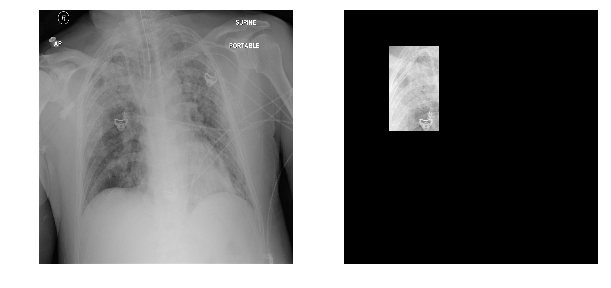

In [20]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Image Augmentation. Try finetuning some variables to custom values

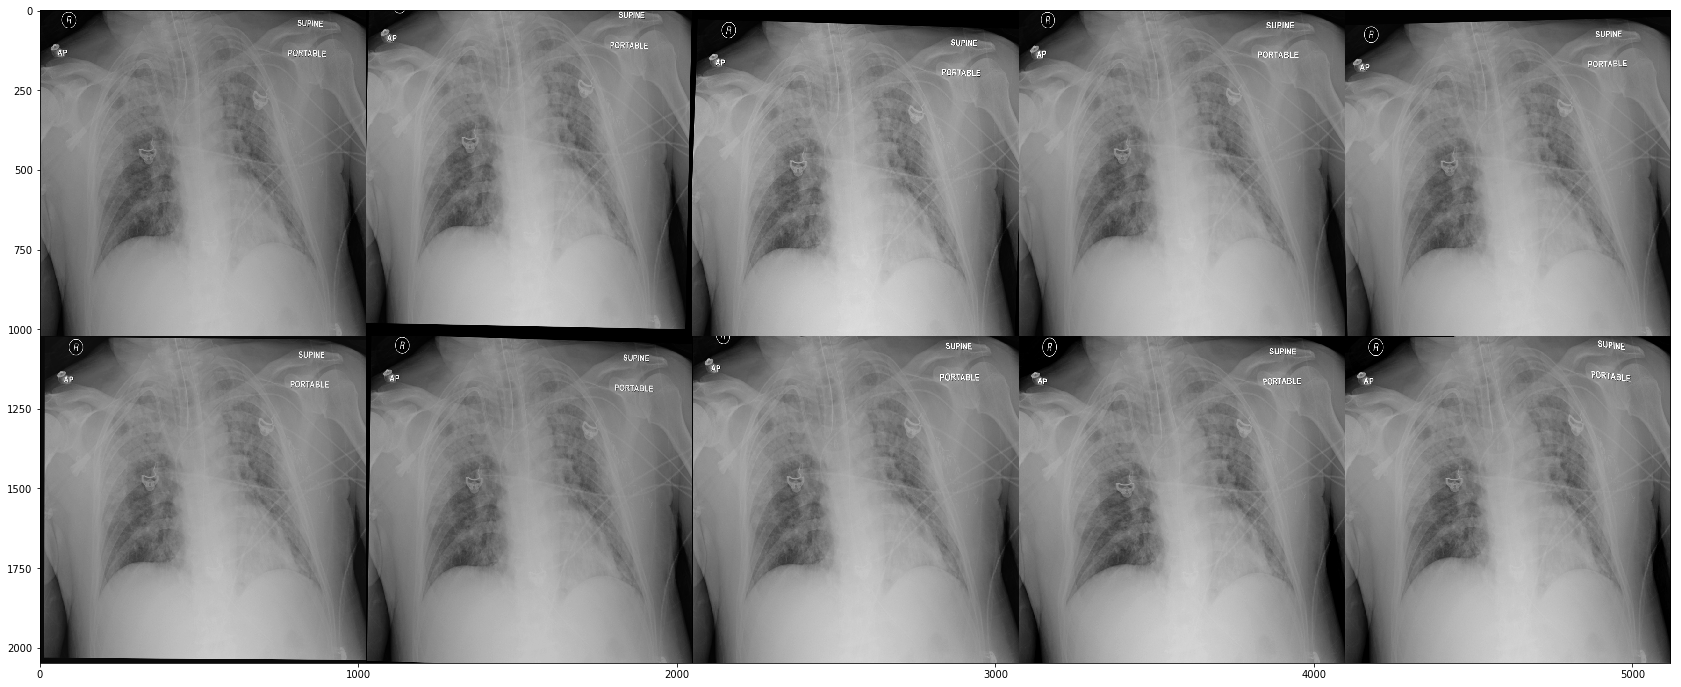

In [21]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

### Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [22]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [23]:
LEARNING_RATE = 0.001

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [24]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=20,
            layers='all',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.001

Checkpoint Path: ../working_coco_script_v32_400_steps_ADAM/pneumonia20181012T1322/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b       

400/400 [==============================] - 329s 822ms/step - loss: 1.0073 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2455 - mrcnn_class_loss: 0.1544 - mrcnn_bbox_loss: 0.2676 - mrcnn_mask_loss: 0.3322 - val_loss: 1.4555 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.3160 - val_mrcnn_class_loss: 0.2950 - val_mrcnn_bbox_loss: 0.4353 - val_mrcnn_mask_loss: 0.3991
Epoch 11/20
400/400 [==============================] - 334s 836ms/step - loss: 0.9349 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.2546 - mrcnn_mask_loss: 0.3206 - val_loss: 1.4178 - val_rpn_class_loss: 0.0114 - val_rpn_bbox_loss: 0.3252 - val_mrcnn_class_loss: 0.2429 - val_mrcnn_bbox_loss: 0.4363 - val_mrcnn_mask_loss: 0.4020
Epoch 12/20
400/400 [==============================] - 342s 856ms/step - loss: 0.9856 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2507 - mrcnn_class_loss: 0.1467 - mrcnn_bbox_loss: 0.2564 - mrcnn_mask_loss: 0.3239 - val_loss: 1.5532 - val_rpn_class_l

Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/home/mehul/miniconda3/envs/tf7/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mehul/miniconda3/envs/tf7/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mehul/miniconda3/envs/tf7/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/mehul/miniconda3/envs/tf7/lib/python3.6/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/home/mehul/.local/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1717, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/mehul/.local/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1218, in load_image_gt

  File "/home/mehul/.local/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 1219, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "/home/mehul/miniconda3/envs/tf7/lib/python3.6/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
Process ForkPoolWorker-8:
  File "/home/mehul/miniconda3/envs/tf7/lib/python3.6/multiprocessing/queues.py", line 347, in put
    self._writer.send_bytes(obj)
  File "/home/mehul/miniconda3/envs/tf7/lib/python3.6/multiprocessing/queues.py", line 346, in put
    with self._wlock:
  File "/home/mehul/miniconda3/envs/tf7/lib/python3.6/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/home/mehul/miniconda3/envs/tf7/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/mehul/.local/lib/python3.6/site-packages/PIL/Im

In [29]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/2,
            epochs=30,
            layers='all',
            augmentation=None)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 20. LR=0.0005

Checkpoint Path: ../working_coco_script_v32_400_steps_ADAM/pneumonia20181012T1322/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b     

Epoch 30/30
400/400 [==============================] - 315s 788ms/step - loss: 0.7110 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1542 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.2804 - val_loss: 1.3696 - val_rpn_class_loss: 0.0087 - val_rpn_bbox_loss: 0.3214 - val_mrcnn_class_loss: 0.2115 - val_mrcnn_bbox_loss: 0.3999 - val_mrcnn_mask_loss: 0.4281
CPU times: user 17min 13s, sys: 47.8 s, total: 18min 1s
Wall time: 57min 24s


In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/4,
            epochs=60,
            layers='all',
            augmentation=None)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [30]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.349098,0.014081,0.358321,0.198754,0.387201,0.390734,1.485748,0.018095,0.322444,0.278240,0.463760,0.403203
2,1.653124,0.013639,0.595446,0.218032,0.442606,0.383393,1.186722,0.010261,0.261076,0.193927,0.350397,0.371055
3,1.626047,0.019311,0.462761,0.235138,0.490702,0.418127,1.082936,0.008235,0.238876,0.157210,0.321268,0.357341
4,1.458377,0.007807,0.406362,0.185555,0.454195,0.404451,1.093740,0.007625,0.252677,0.166200,0.311108,0.356123
5,1.675815,0.012937,0.373769,0.349015,0.507253,0.432835,1.090884,0.007946,0.252100,0.163443,0.309834,0.357555
6,1.374572,0.010563,0.335947,0.246299,0.399773,0.381983,1.044308,0.007385,0.237831,0.172009,0.292057,0.335019
7,1.446139,0.011902,0.333238,0.222784,0.452006,0.426203,0.947942,0.006451,0.202075,0.142298,0.268717,0.328394
8,1.634415,0.020356,0.664779,0.157376,0.393686,0.398212,0.913341,0.007549,0.199692,0.136726,0.247099,0.322267
9,1.335309,0.008901,0.320913,0.199815,0.396542,0.409131,0.961212,0.007057,0.211710,0.152199,0.259490,0.330748
10,1.455532,0.010097,0.316047,0.294954,0.435311,0.399115,1.007257,0.007500,0.245511,0.154450,0.267615,0.332174


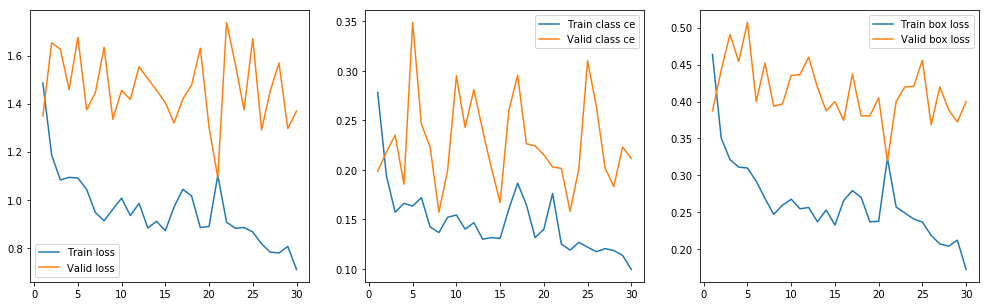

In [31]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [32]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1)

Best Epoch: 21


In [42]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    print(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[28])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

['mask_rcnn_pneumonia_0001.h5', 'mask_rcnn_pneumonia_0002.h5', 'mask_rcnn_pneumonia_0003.h5', 'mask_rcnn_pneumonia_0004.h5', 'mask_rcnn_pneumonia_0005.h5', 'mask_rcnn_pneumonia_0006.h5', 'mask_rcnn_pneumonia_0007.h5', 'mask_rcnn_pneumonia_0008.h5', 'mask_rcnn_pneumonia_0009.h5', 'mask_rcnn_pneumonia_0010.h5', 'mask_rcnn_pneumonia_0011.h5', 'mask_rcnn_pneumonia_0012.h5', 'mask_rcnn_pneumonia_0013.h5', 'mask_rcnn_pneumonia_0014.h5', 'mask_rcnn_pneumonia_0015.h5', 'mask_rcnn_pneumonia_0016.h5', 'mask_rcnn_pneumonia_0017.h5', 'mask_rcnn_pneumonia_0018.h5', 'mask_rcnn_pneumonia_0019.h5', 'mask_rcnn_pneumonia_0020.h5', 'mask_rcnn_pneumonia_0021.h5', 'mask_rcnn_pneumonia_0022.h5', 'mask_rcnn_pneumonia_0023.h5', 'mask_rcnn_pneumonia_0024.h5', 'mask_rcnn_pneumonia_0025.h5', 'mask_rcnn_pneumonia_0026.h5', 'mask_rcnn_pneumonia_0027.h5', 'mask_rcnn_pneumonia_0028.h5', 'mask_rcnn_pneumonia_0029.h5', 'mask_rcnn_pneumonia_0030.h5']
[]
No weight files in ../working_coco_script_v32_400_steps_ADAM/pneum

In [43]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../working_coco_script_v32_400_steps_ADAM/pneumonia20181012T1322/mask_rcnn_pneumonia_0029.h5
Re-starting from epoch 29


In [44]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs. 

(512, 512, 3)

*** No instances to display *** 

(512, 512, 3)

*** No instances to display *** 

(512, 512, 3)

*** No instances to display *** 

(512, 512, 3)

*** No instances to display *** 


*** No instances to display *** 

(512, 512, 3)

*** No instances to display *** 

(512, 512, 3)


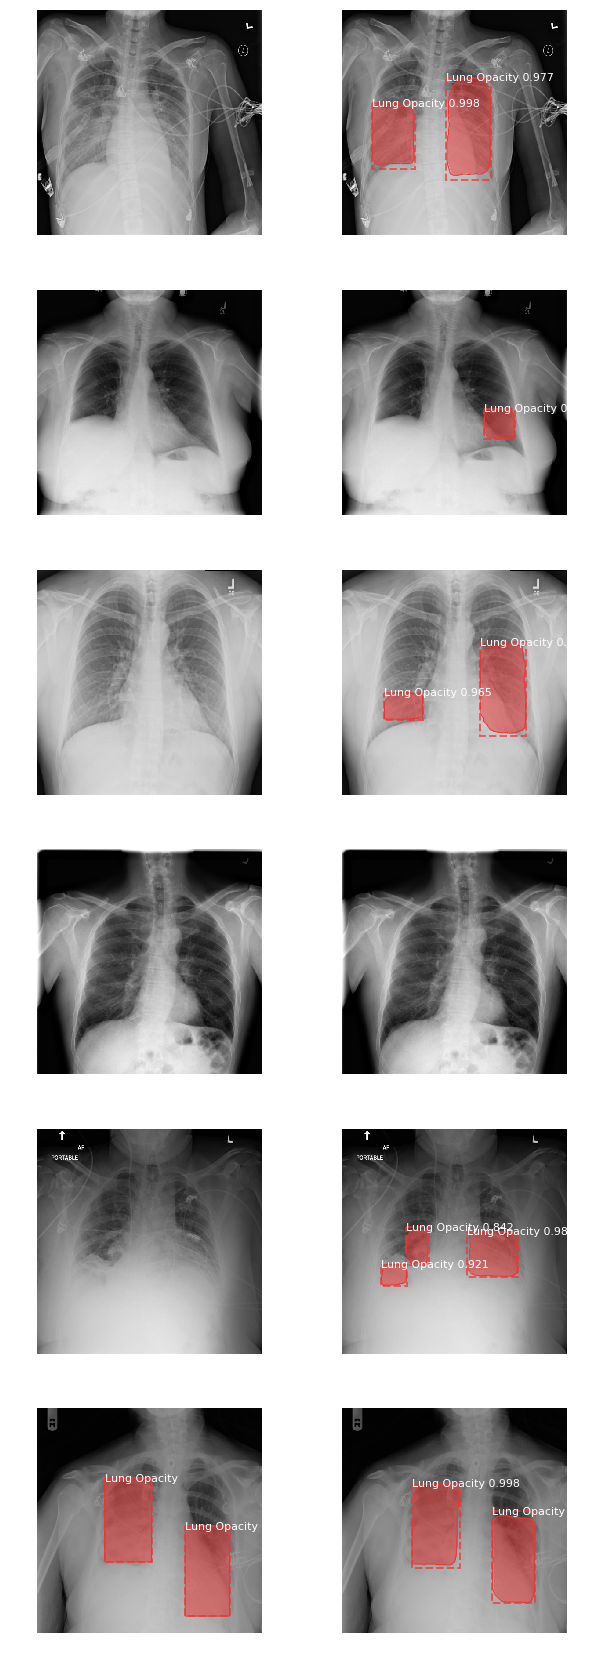

In [45]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [39]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

### Final steps - Create the submission file

In [40]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [46]:
submission_fp = os.path.join(ROOT_DIR, 'submission-512x512-400-steps-coco-weights-0.95-ADAM-29-epochs.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 1000/1000 [02:09<00:00,  7.72it/s]

../working_coco_script_v32_400_steps_ADAM/submission-512x512-400-steps-coco-weights-0.95-ADAM-29-epochs.csv


In [ ]:
output = pd.read_csv(submission_fp)
output.head(60)

0f68958e-1720-4511-a9c2-b1d217d92243
[334 107 446 218]
x 214 y 668 h 222 w 224
[324 306 432 415]
x 612 y 648 h 218 w 216
0444a527-72cf-4bc9-b17f-100cf7acc889
[234 116 334 236]
x 232 y 468 h 240 w 200
[288 347 360 442]
x 694 y 576 h 190 w 144
1d5af9ab-1f62-47b2-980f-71e8409d7c3c
[192 294 305 430]
x 588 y 384 h 272 w 226
[255 151 368 219]
x 302 y 510 h 136 w 226
0049f7b2-229b-4a46-91a3-0e321a3ca80a
[ 75 124 268 228]
x 248 y 150 h 208 w 386
[168 291 368 415]
x 582 y 336 h 248 w 400


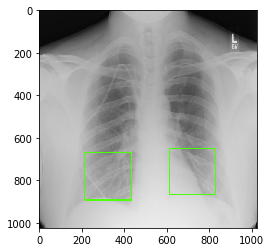

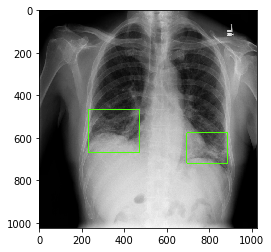

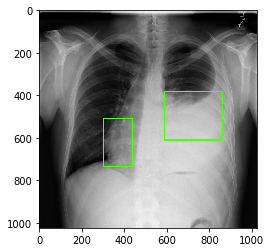

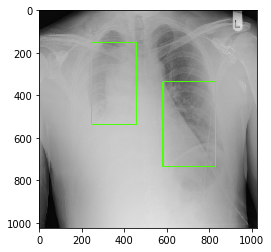

In [35]:
# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()

In [ ]:
# remove files to allow committing (hit files limit otherwise)
!rm -rf /kaggle/working/Mask_RCNN